# **1. Setting up**

In [18]:
pip install imbalanced-learn

In [34]:
from sklearn.model_selection import train_test_split, cross_val_score # Import train_test_split function
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#import utils, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
data = pd.read_csv('/content/drive/MyDrive/final_dataset.csv')
print(data.shape)
data.head()

(451325, 19)


,acousticness,artist_name,danceability,duration_m,energy,explicit,instrumentalness,key,liveness,loudness,mode,month,popularity,preview_url,speechiness,tempo,track_id,valence,year
0,0.00126,Headhunterz,0.355,2.943667,0.881,f,0.000002,9,0.0694,-3.962,1,7,26.0,https://p.scdn.co/mp3-preview/4229181352cb0c16...,0.1800,75,7o7Qx3kulN6A0uOaAPf5Vz,0.190,2022
1,0.18700,Headhunterz,0.552,3.902767,0.829,f,0.000054,6,0.2830,-4.988,0,9,51.0,https://p.scdn.co/mp3-preview/4d5c7620737fbd8e...,0.0845,150,0zolxiS5uiL5towOJrsJi4,0.367,2019
2,0.02730,Crossing Colors,0.839,5.818183,0.721,f,0.900000,9,0.0667,-7.721,0,7,9.0,https://p.scdn.co/mp3-preview/d8e54d5d229948b9...,0.0477,110,6AJ1Rk1khe1egig27nXImU,0.768,2018
3,0.01430,Brennan Heart,0.543,3.520000,0.827,f,0.000000,1,0.0842,-3.585,0,5,46.0,https://p.scdn.co/mp3-preview/a8e60e3bd2defda5...,0.0350,150,2KM4KCDbbfOvQ5cgWADd0Z,0.123,2021
4,0.01080,Brennan Heart,0.623,3.946667,0.832,f,0.000000,1,0.0487,-3.348,0,5,17.0,https://p.scdn.co/mp3-preview/758c6b9f2ff9b87b...,0.0566,150,7t2gGVF4Q7QnFM9dt9F0qE,0.439,2021


# **2. Exploring Data and Categorization**

In [22]:
new_data = data.drop(['artist_name','month','popularity','preview_url','track_id','year','explicit'],axis=1)
new_data['popularity']=data['popularity']
# Label for popularity //
   #1 --> Low,
   #2 --> Medium,
   #3 --> High
new_data['label'] = pd.cut(new_data.popularity, bins=3, labels=[1, 2, 3], right=True)
db = new_data.drop(['popularity'],axis=1)
db.head()

,acousticness,danceability,duration_m,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,label
0,0.00126,0.355,2.943667,0.881,0.000002,9,0.0694,-3.962,1,0.1800,75,0.190,1
1,0.18700,0.552,3.902767,0.829,0.000054,6,0.2830,-4.988,0,0.0845,150,0.367,2
2,0.02730,0.839,5.818183,0.721,0.900000,9,0.0667,-7.721,0,0.0477,110,0.768,1
3,0.01430,0.543,3.520000,0.827,0.000000,1,0.0842,-3.585,0,0.0350,150,0.123,2
4,0.01080,0.623,3.946667,0.832,0.000000,1,0.0487,-3.348,0,0.0566,150,0.439,1


        Samples_qty  Samples_percentage
LOW          436277            0.966658
MEDIUM        14652            0.032464
HIGH            396            0.000877
___________________________________________________________________________


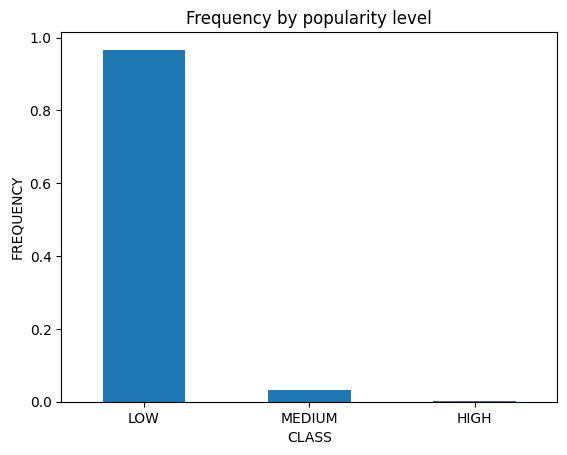

In [23]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
                 Bbox = dict(facecolor = 'red', alpha =.8))

Samples_qty = db.label.value_counts()
Samples_percentage = db.label.value_counts(normalize=True)
data_transposed = zip(Samples_qty,Samples_percentage)
results = pd.DataFrame(data_transposed, index=['LOW','MEDIUM','HIGH'], columns=["Samples_qty", "Samples_percentage"])
print(results)
print('___________________________________________________________________________')
count_classes = pd.value_counts(db['label'], sort = True, normalize=True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(3),labels=["LOW","MEDIUM","HIGH"])
plt.title("Frequency by popularity level")
plt.xlabel("CLASS")
plt.ylabel("FREQUENCY");

It is clear that the category for popularity shows unbalanced distribution being the songs with low popularity with most representation. Under this scenery, it is necessary to apply certain methods to solve this issue since training this dataset may obtain high accuracy for the majority class ("Low") but with a poor values in recall and precision for the other class. So, before training dataset, it will be applied specific techniques to balance the classes.

# **3. ENGINEERING DATA AND NORMALIZATION**

It was split the training and target blocks before applying the transformations to improve the classification.

In [24]:
X = db.drop(['label'],axis=1)
y = db[['label']]

With the next section, it will be highlighted the most relevant columns to perform the classification.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

select = RFE(DecisionTreeClassifier(random_state = 3000), n_features_to_select = 5)
select.fit(X_train,y_train)
X_train_selected = select.transform(X_train)
X_test_selected = select.transform(X_test)
rfe_columns = []
for i in range(len(select.get_support())):
    if select.get_support()[i] == True:
        rfe_columns.append(X.columns[i])

rfe_columns

['acousticness', 'duration_m', 'liveness', 'loudness', 'valence']

In [26]:
rfe_columns.remove('duration_m')
rfe_columns

['acousticness', 'liveness', 'loudness', 'valence']

Get scaled the dataset with the next methods: minmax, standard and robust
Before applying machine learning methods the dataset needs to be scaled to a standard range with the next methods: minmax, standard and robust

In [27]:
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler()]

for i in range(len(scalers)):
    #create the scaler
    scaler = scalers[i]
    #fit the scaler to the training data(features only)
    scaler.fit(X)
    if i == 0:
        minmax_scaled = scaler.transform(X)
    elif i == 1:
        standard_scaled = scaler.transform(X)
    elif i == 2:
        robust_scaled = scaler.transform(X)

features_standard_scaled = pd.DataFrame(standard_scaled, columns = X.columns)[rfe_columns]
features_minmax_scaled = pd.DataFrame(minmax_scaled, columns = X.columns)[rfe_columns]
features_robust_scaled = pd.DataFrame(robust_scaled, columns = X.columns)[rfe_columns]
X= pd.DataFrame(X,columns=X.columns)[rfe_columns]

In [28]:
# Dictionary with features both scaled and unscaled to evaluate the performance
all_data = {'UNSCALED FEATURES' : X, 'STANDARD SCALER' : features_standard_scaled, 'MINMAX SCALER' : features_minmax_scaled, 'ROBUST SCALER' : features_robust_scaled}

So far, it will be analysed every input dataset including the non-scaled data, just for appreciating the influence of this previous step.

# **4. Training dataset**

Previous to training dataset, it will be applied the resample methods in order to balance the category of popularity. This resample methods are:
  


*   Synthetic Minority Oversampling Technique (SMOTE)
*   SMOTETomek
*   Random Over Sampling

which consist on adding more data to the least sample containing class.

UNSCALED FEATURES 
-----------------

              precision    recall  f1-score   support

           1       0.86      0.81      0.84     87002
           2       0.83      0.87      0.85     87510
           3       0.98      0.99      0.99     87255

    accuracy                           0.89    261767
   macro avg       0.89      0.89      0.89    261767
weighted avg       0.89      0.89      0.89    261767

	Prediction accuracy on the test data:  89.13%

STANDARD SCALER 
-----------------

              precision    recall  f1-score   support

           1       0.87      0.82      0.85     87002
           2       0.84      0.88      0.86     87510
           3       0.98      0.99      0.99     87255

    accuracy                           0.90    261767
   macro avg       0.90      0.90      0.90    261767
weighted avg       0.90      0.90      0.90    261767

	Prediction accuracy on the test data:  89.85%

MINMAX SCALER 
-----------------

              precision    recall 

<Axes: >

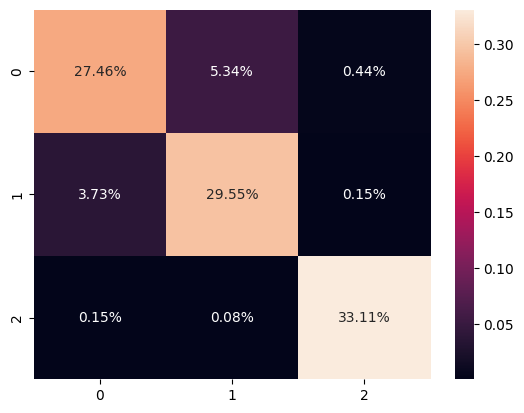

In [29]:
acc_smote = []
for scaler_name, scaler_data in all_data.items():
  new_y = y
  print(scaler_name, '\n-----------------\n')
  clasiffier = DecisionTreeClassifier()
  smote = SMOTE(sampling_strategy='auto', random_state=42)
  X_sampled, y_sampled = smote.fit_resample(scaler_data, new_y)
  X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)
  classifier = clasiffier.fit(X_train,y_train)
  training_accuracy = clasiffier.score(X_train, y_train)
  test_accuracy = clasiffier.score(X_test, y_test)
  acc_smote.append(test_accuracy)
  y_pred = clasiffier.predict(X_test)
  print(classification_report(y_test,y_pred))
  #print('\t' + f'Prediction accuracy on the training data: {training_accuracy: .2%}')
  print('\t' + f'Prediction accuracy on the test data: {test_accuracy: .2%}\n')
cf_matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')

UNSCALED FEATURES 
-----------------

              precision    recall  f1-score   support

           1       0.87      0.82      0.84     85722
           2       0.84      0.88      0.86     86538
           3       0.98      0.99      0.99     87200

    accuracy                           0.90    259460
   macro avg       0.90      0.90      0.90    259460
weighted avg       0.90      0.90      0.90    259460

	Prediction accuracy on the test data:  89.62%

STANDARD SCALER 
-----------------

              precision    recall  f1-score   support

           1       0.88      0.82      0.85     86086
           2       0.84      0.88      0.86     86568
           3       0.98      0.99      0.99     87256

    accuracy                           0.90    259910
   macro avg       0.90      0.90      0.90    259910
weighted avg       0.90      0.90      0.90    259910

	Prediction accuracy on the test data:  90.12%

MINMAX SCALER 
-----------------

              precision    recall 

<Axes: >

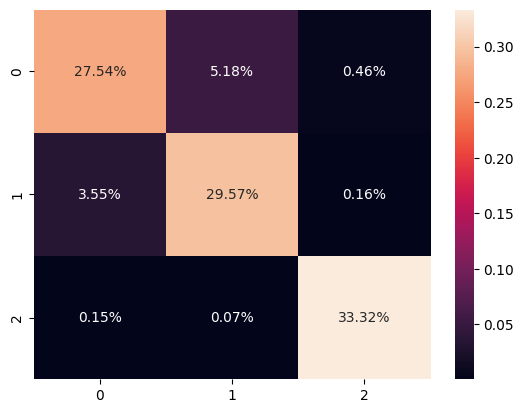

In [30]:
acc_smk = []
for scaler_name, scaler_data in all_data.items():
  new_y = y
  print(scaler_name, '\n-----------------\n')
  clasiffier0 = DecisionTreeClassifier()
  smk = SMOTETomek()
  X_sampled, y_sampled = smk.fit_resample(scaler_data, new_y)
  X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)
  classifier0 = clasiffier0.fit(X_train,y_train)
  training_accuracy = clasiffier0.score(X_train, y_train)
  test_accuracy = clasiffier0.score(X_test, y_test)
  y_pred = clasiffier0.predict(X_test)
  acc_smk.append(test_accuracy)
  print(classification_report(y_test,y_pred))
  #print('\t' + f'Prediction accuracy on the training data: {training_accuracy: .2%}')
  print('\t' + f'Prediction accuracy on the test data: {test_accuracy: .2%}\n')
cf_matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')

UNSCALED FEATURES 
-----------------

              precision    recall  f1-score   support

           1       1.00      0.96      0.98     87002
           2       0.96      1.00      0.98     87510
           3       1.00      1.00      1.00     87255

    accuracy                           0.99    261767
   macro avg       0.99      0.99      0.99    261767
weighted avg       0.99      0.99      0.99    261767

	Prediction accuracy on the test data:  98.63%

STANDARD SCALER 
-----------------

              precision    recall  f1-score   support

           1       1.00      0.96      0.98     87002
           2       0.96      1.00      0.98     87510
           3       1.00      1.00      1.00     87255

    accuracy                           0.99    261767
   macro avg       0.99      0.99      0.99    261767
weighted avg       0.99      0.99      0.99    261767

	Prediction accuracy on the test data:  98.67%

MINMAX SCALER 
-----------------

              precision    recall 

<Axes: >

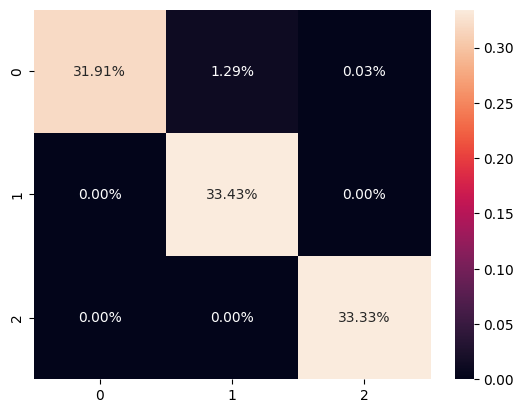

In [31]:
acc_ros = []
for scaler_name, scaler_data in all_data.items():
  new_y = y
  print(scaler_name, '\n-----------------\n')
  clasiffier3 = DecisionTreeClassifier()
  ROS = RandomOverSampler()
  X_sampled, y_sampled = ROS.fit_resample(scaler_data, new_y)
  X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)
  classifier3 = clasiffier3.fit(X_train,y_train)
  training_accuracy = clasiffier3.score(X_train, y_train)
  test_accuracy = clasiffier3.score(X_test, y_test)
  y_pred = clasiffier3.predict(X_test)
  acc_ros.append(test_accuracy)
  print(classification_report(y_test,y_pred))
  #print('\t' + f'Prediction accuracy on the training data: {training_accuracy: .2%}')
  print('\t' + f'Prediction accuracy on the test data: {test_accuracy: .2%}\n')
cf_matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')

## **5. Results**

In [32]:
#accuracy = [acc_smote,acc_smk,acc_ros]
#sd = np.transpose(pd.DataFrame(accuracy))
index = ['unscaled', 'standard', 'min_max', 'robust']
columns = ['SMOTE', 'SMK', 'ROS']
acc_sum = pd.DataFrame((zip(acc_smote,acc_smk,acc_ros)),index=index, columns=columns).round(3)
# Values in percentage
acc_sum = acc_sum*100
acc_sum

,SMOTE,SMK,ROS
unscaled,89.1,89.6,98.6
standard,89.9,90.1,98.7
min_max,89.9,90.2,98.7
robust,90.1,90.4,98.7


As it can see, combining the sampling techniques and stadardization method, it has got over **89% of accuracy**

<Axes: >

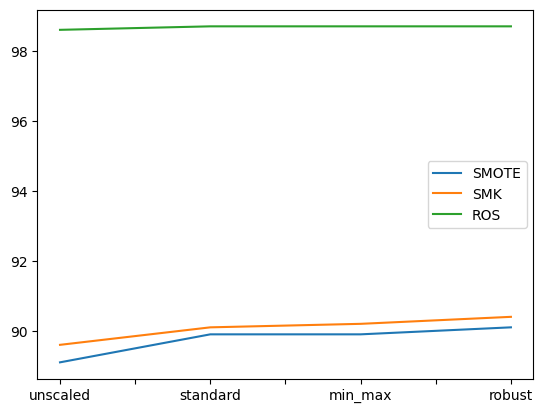

In [33]:
acc_sum.plot()

According to the results by mapping the accuracy values considering the different sampling techniques and at the same time the type of standardization, it is clear the best standardization method is **"robustscaler"** as that contributes with a highest accuracy among the different methods of standardization.
Regarding to the sampling techniques is observed that RandomOverSampling (ROS) got the highest accuracy; however it was discarded due to its high accuracy as it may overfitted the model. By contrast, applying **SMOTETomek (SMK)** and SMOTE  got the same values being selected the **SMK** technique since, among these last two, it grants a better accuracy and it is possible to get better generalisation for the classification of the dataset.   

To sum up:
Sampling technique : SMOTETomek
Stadardization method : RobustScaler